# Category-Level Regime Analysis

Apply PELT changepoint detection and Chow test validation to category-level retail data.

**Approach**:
1. Apply PELT to aggregate `all_retail_ex_fuel` → identify universal breakpoints
2. Validate breakpoints with Chow test
3. Test breakpoints on individual categories (informational)
4. Profile each category by regime (pre-COVID, COVID, post-COVID)
5. Calculate reversion metrics

## 0. Setup

In [1]:
import pandas as pd
import numpy as np
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from ruptures import Pelt
import statsmodels.api as sm
from scipy import stats

In [2]:
# Chart style settings
import matplotlib.style as style
style.use({
    'font.family': 'Monospace',
    'font.size': 12,
})

In [3]:
# Data folders
processed_data_dir = Path.cwd().parent / "data" / "processed"
output_figures_dir = Path.cwd().parent / "outputs" / "figures"
output_figures_dir.mkdir(parents=True, exist_ok=True)

In [4]:
# Spans for time series charts
def add_event_spans(ax):
    return {
        'covid1': ax.axvspan(pd.Timestamp('2020-03'), pd.Timestamp('2020-05'),
                             color="#4BADFEBF", alpha=0.2, hatch='/', label='1st COVID lock-down'),
        'covid2': ax.axvspan(pd.Timestamp('2020-11'), pd.Timestamp('2020-12'),
                             color="#4BADFE81", alpha=0.2, hatch='//', label='2nd COVID lock-down'),
        'covid3': ax.axvspan(pd.Timestamp('2021-01'), pd.Timestamp('2021-04'),
                             color="#4BADFE4D", alpha=0.2, hatch='///', label='3rd COVID lock-down'),
        'energy': ax.axvspan(pd.Timestamp('2021-10'), pd.Timestamp('2022-10'),
                             color="#4B8AFEBE", alpha=0.2, label='Energy-price crisis')
    }

In [5]:
# Load category data
file_path = processed_data_dir / "category_data.pkl"
df_categories = pd.read_pickle(file_path)

# Load metadata
meta_path = processed_data_dir / "category_metadata.pkl"
with open(meta_path, 'rb') as f:
    metadata = pickle.load(f)

print(f'Loaded {len(df_categories.columns)} categories')
print(f'Time range: {df_categories.index.min()} to {df_categories.index.max()}')
print(f'Total observations: {len(df_categories)}')
df_categories.info()

Loaded 8 categories
Time range: 2015-01-31 00:00:00 to 2025-07-31 00:00:00
Total observations: 127
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 127 entries, 2015-01-31 to 2025-07-31
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   all_retail_ex_fuel  127 non-null    float64
 1   food_stores         127 non-null    float64
 2   non_food_total      127 non-null    float64
 3   non_specialised     127 non-null    float64
 4   clothing_footwear   127 non-null    float64
 5   household_goods     127 non-null    float64
 6   other_stores        127 non-null    float64
 7   non_store_retail    127 non-null    float64
dtypes: float64(8)
memory usage: 8.9 KB


## 1. PELT Changepoint Detection on Aggregate

In [6]:
# Apply PELT to aggregate series (all_retail_ex_fuel)
data = df_categories['all_retail_ex_fuel'].values

# Use L1 norm, min_size=12 months to prevent spurious short segments
model_pelt = Pelt(model='l1', min_size=12, jump=1)

# Test different penalty values
penalties = [10, 25, 50]
print('=' * 100)
print('PELT CHANGEPOINT DETECTION - AGGREGATE (all_retail_ex_fuel)')
print('=' * 100)

for pen in penalties:
    result = model_pelt.fit_predict(data, pen=pen)
    changepoints = result[:-1]  # Remove last index (end of series)
    dates = [df_categories.index[i].strftime('%Y-%m-%d') for i in changepoints]
    print(f'Penalty {pen:3d}: {len(changepoints)} changepoints at indices {changepoints} → dates {dates}')

PELT CHANGEPOINT DETECTION - AGGREGATE (all_retail_ex_fuel)
Penalty  10: 4 changepoints at indices [20, 34, 63, 85] → dates ['2016-09-30', '2017-11-30', '2020-04-30', '2022-02-28']
Penalty  25: 3 changepoints at indices [21, 63, 85] → dates ['2016-10-31', '2020-04-30', '2022-02-28']
Penalty  50: 2 changepoints at indices [21, 63] → dates ['2016-10-31', '2020-04-30']


In [8]:
# Select penalty=25 (balances detection vs overfitting)
result = model_pelt.fit(data).predict(pen=25)
changepoints_pelt = result[:-1]

print(f'\nSelected penalty=25 → {len(changepoints_pelt)} changepoints')
for idx in changepoints_pelt:
    print(f'  Index {idx:3d} → {df_categories.index[idx].strftime("%Y-%m-%d")}')


Selected penalty=25 → 3 changepoints
  Index  21 → 2016-10-31
  Index  63 → 2020-04-30
  Index  85 → 2022-02-28


## 2. Chow Test Validation

In [9]:
# Validate changepoints with Chow test
y = df_categories['all_retail_ex_fuel'].values
n = len(y)
trend = np.arange(n)
dates = df_categories.index

# Bonferroni correction for multiple testing
alpha_bonf = 0.05 / len(changepoints_pelt)

print('=' * 100)
print('CHOW TEST VALIDATION')
print('=' * 100)
print(f'Testing {len(changepoints_pelt)} changepoints with Bonferroni-corrected alpha = {alpha_bonf:.4f}\n')

changepoints_validated = []

for k in changepoints_pelt:
    break_date = dates[k]

    # Create dummy: 0 before break, 1 from break onward
    D = np.zeros(n)
    D[k:] = 1

    # Create interaction term (trend * dummy)
    trend_interaction = trend * D

    # Restricted model: no break (constant + trend)
    X_restricted = sm.add_constant(trend)
    res_r = sm.OLS(y, X_restricted).fit()

    # Unrestricted model: with break (constant + trend + dummy + interaction)
    X_unrestricted = sm.add_constant(np.column_stack([trend, D, trend_interaction]))
    res_u = sm.OLS(y, X_unrestricted).fit()

    # Chow F-statistic
    q = 2  # Number of restrictions (dummy + interaction)
    df1 = q
    df2 = res_u.df_resid

    f_stat = ((res_r.ssr - res_u.ssr) / df1) / (res_u.ssr / df2)
    p_val = 1 - stats.f.cdf(f_stat, df1, df2)

    print(f'Breakpoint index {k:3d} → {break_date.strftime("%Y-%m-%d")}')
    print(f'  Chow F({df1},{int(df2)}) = {f_stat:.3f}, p = {p_val:.4f}')

    if p_val < alpha_bonf:
        print(f'  → ✅ SIGNIFICANT (p < {alpha_bonf:.4f})\n')
        changepoints_validated.append(k)
    else:
        print(f'  → ❌ Not significant (p >= {alpha_bonf:.4f})\n')

print('=' * 100)
print(f'VALIDATED CHANGEPOINTS: {len(changepoints_validated)}')
print('=' * 100)
for idx in changepoints_validated:
    print(f'  Index {idx:3d} → {df_categories.index[idx].strftime("%Y-%m-%d")}')

CHOW TEST VALIDATION
Testing 3 changepoints with Bonferroni-corrected alpha = 0.0167

Breakpoint index  21 → 2016-10-31
  Chow F(2,123) = 3.206, p = 0.0439
  → ❌ Not significant (p >= 0.0167)

Breakpoint index  63 → 2020-04-30
  Chow F(2,123) = 166.509, p = 0.0000
  → ✅ SIGNIFICANT (p < 0.0167)

Breakpoint index  85 → 2022-02-28
  Chow F(2,123) = 55.767, p = 0.0000
  → ✅ SIGNIFICANT (p < 0.0167)

VALIDATED CHANGEPOINTS: 2
  Index  63 → 2020-04-30
  Index  85 → 2022-02-28


## 3. Visualize Aggregate Changepoints

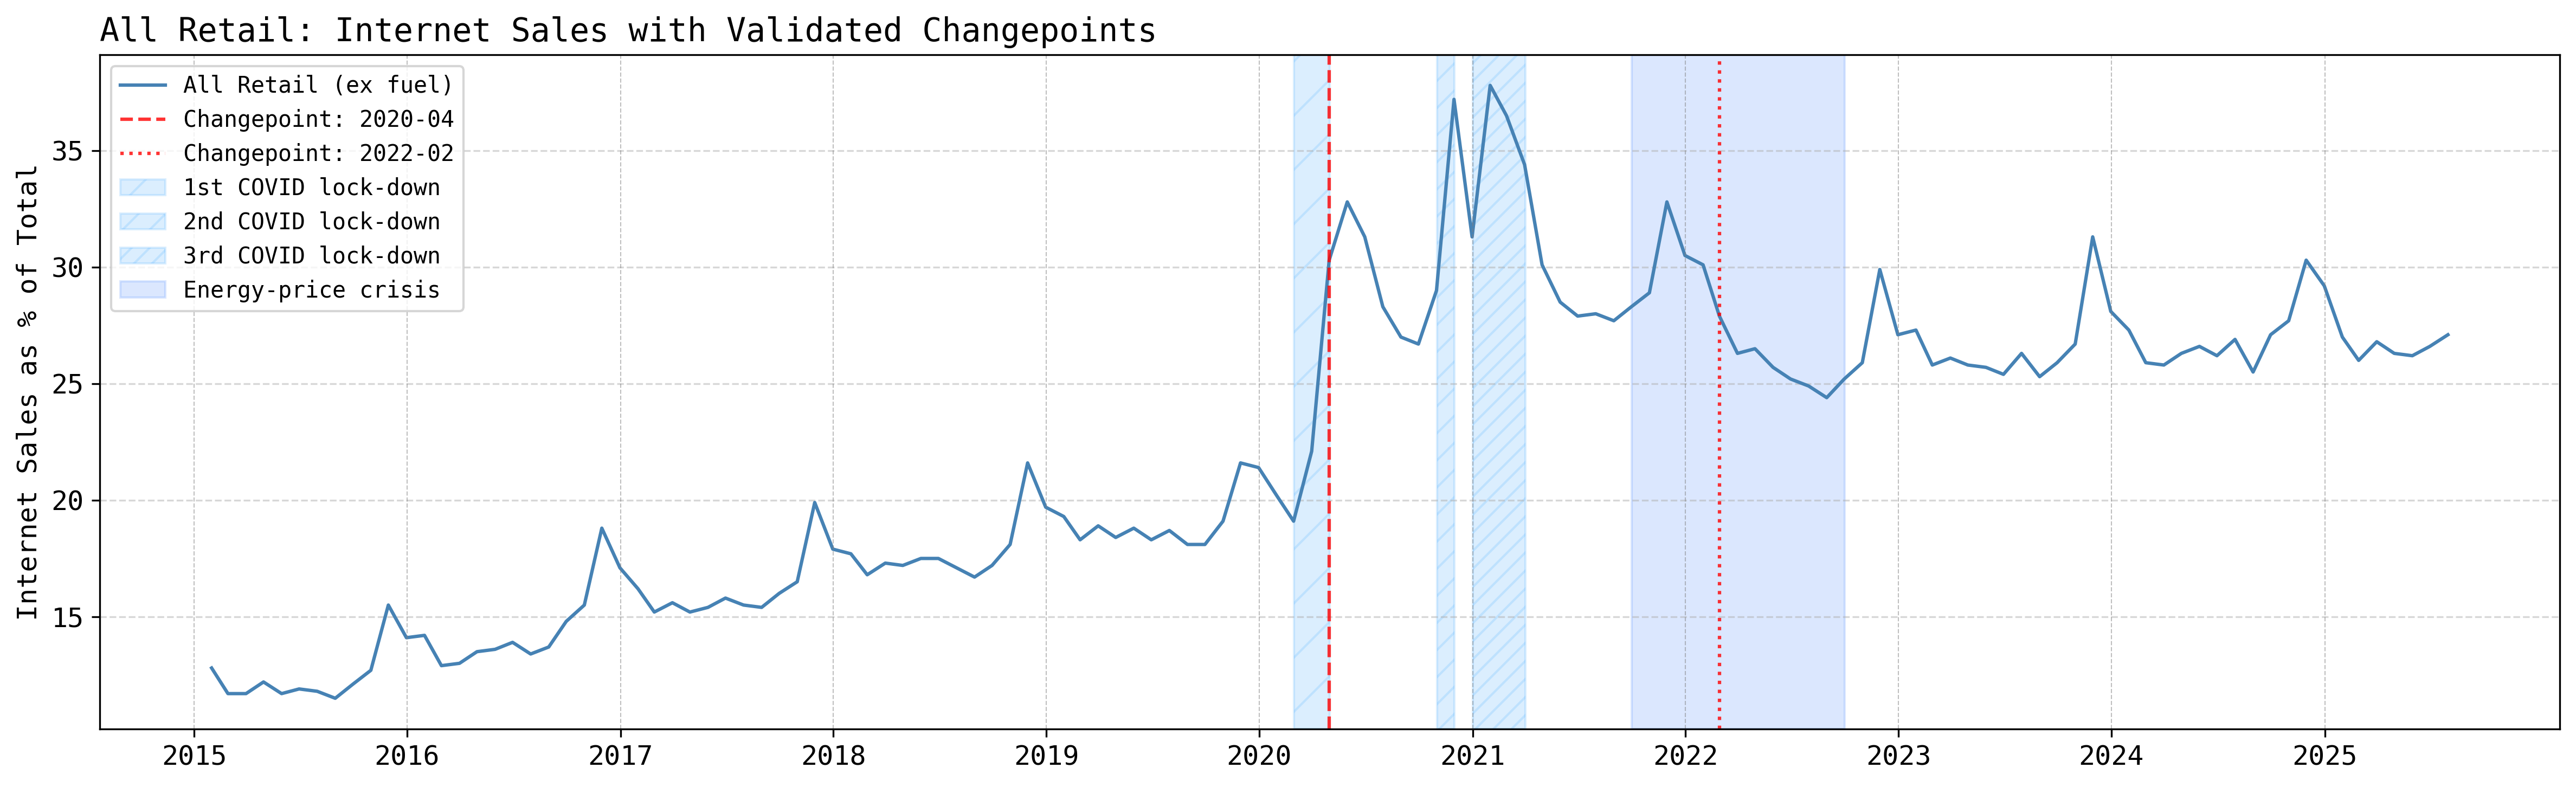

In [10]:
# Plot aggregate with validated changepoints
plt.figure(figsize=(16, 5), dpi=300)
ax = plt.gca()

# Plot aggregate series
ax.plot(df_categories.index, df_categories['all_retail_ex_fuel'],
        linewidth=1.5, color='steelblue', label='All Retail (ex fuel)')

# Add validated changepoints
linestyles = ['--', ':', '-.']
for i, cp in enumerate(changepoints_validated):
    current_linestyle = linestyles[i % len(linestyles)]
    ax.axvline(x=df_categories.index[cp], color='red', linestyle=current_linestyle,
               alpha=0.8, linewidth=1.5, label=f'Changepoint: {df_categories.index[cp].strftime("%Y-%m")}')

# Add event spans
event_spans = add_event_spans(ax)

# Formatting
ax.set_xticks([pd.Timestamp(f'{year}-01-01') for year in range(2015, 2026)])
ax.set_xticklabels([str(year) for year in range(2015, 2026)])
for tick in ax.get_xticks():
    ax.axvline(x=tick, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

ax.legend(loc='upper left', fontsize=10)
ax.set_xlabel('')
ax.set_ylabel('Internet Sales as % of Total')
ax.grid(axis='y', linestyle='--', alpha=0.5)
ax.set_title('All Retail: Internet Sales with Validated Changepoints', loc='left')

plt.tight_layout()
plt.savefig(output_figures_dir / 'category_aggregate_changepoints.png', bbox_inches='tight', dpi=300)
plt.show()

## 4. Test Changepoints on Individual Categories

In [11]:
# Test aggregate breakpoints on each individual category (informational)
# This shows whether universal breakpoints are significant per category

categories_to_test = [
    'food_stores',
    'clothing_footwear',
    'household_goods',
    'non_specialised',
    'other_stores',
    'non_store_retail'
]

print('=' * 100)
print('CHOW TEST: AGGREGATE CHANGEPOINTS APPLIED TO INDIVIDUAL CATEGORIES')
print('=' * 100)
print(f'Testing universal breakpoints from aggregate on each category\n')

# Store results for summary table
chow_results = {}

for category in categories_to_test:
    print(f'\n{"=" * 100}')
    print(f'Category: {category.replace("_", " ").title()}')
    print(f'{"=" * 100}')

    y = df_categories[category].values
    n = len(y)
    trend = np.arange(n)
    dates = df_categories.index

    alpha_bonf = 0.05 / len(changepoints_validated)
    category_results = []

    for k in changepoints_validated:
        break_date = dates[k]

        # Create dummy and interaction
        D = np.zeros(n)
        D[k:] = 1
        trend_interaction = trend * D

        # Restricted and unrestricted models
        X_restricted = sm.add_constant(trend)
        res_r = sm.OLS(y, X_restricted).fit()

        X_unrestricted = sm.add_constant(np.column_stack([trend, D, trend_interaction]))
        res_u = sm.OLS(y, X_unrestricted).fit()

        # Chow F-statistic
        q = 2
        df1 = q
        df2 = res_u.df_resid

        f_stat = ((res_r.ssr - res_u.ssr) / df1) / (res_u.ssr / df2)
        p_val = 1 - stats.f.cdf(f_stat, df1, df2)

        is_significant = p_val < alpha_bonf
        status = '✅ SIGNIFICANT' if is_significant else '❌ Not significant'

        print(f'  Breakpoint {break_date.strftime("%Y-%m")}: F({df1},{int(df2)}) = {f_stat:7.3f}, p = {p_val:.4f} → {status}')

        category_results.append({
            'date': break_date,
            'f_stat': f_stat,
            'p_val': p_val,
            'significant': is_significant
        })

    chow_results[category] = category_results

CHOW TEST: AGGREGATE CHANGEPOINTS APPLIED TO INDIVIDUAL CATEGORIES
Testing universal breakpoints from aggregate on each category


Category: Food Stores
  Breakpoint 2020-04: F(2,123) = 340.437, p = 0.0000 → ✅ SIGNIFICANT
  Breakpoint 2022-02: F(2,123) =  27.532, p = 0.0000 → ✅ SIGNIFICANT

Category: Clothing Footwear
  Breakpoint 2020-04: F(2,123) =  58.639, p = 0.0000 → ✅ SIGNIFICANT
  Breakpoint 2022-02: F(2,123) =  24.462, p = 0.0000 → ✅ SIGNIFICANT

Category: Household Goods
  Breakpoint 2020-04: F(2,123) =  71.944, p = 0.0000 → ✅ SIGNIFICANT
  Breakpoint 2022-02: F(2,123) =  19.711, p = 0.0000 → ✅ SIGNIFICANT

Category: Non Specialised
  Breakpoint 2020-04: F(2,123) = 103.588, p = 0.0000 → ✅ SIGNIFICANT
  Breakpoint 2022-02: F(2,123) =  42.755, p = 0.0000 → ✅ SIGNIFICANT

Category: Other Stores
  Breakpoint 2020-04: F(2,123) =  60.129, p = 0.0000 → ✅ SIGNIFICANT
  Breakpoint 2022-02: F(2,123) =  15.737, p = 0.0000 → ✅ SIGNIFICANT

Category: Non Store Retail
  Breakpoint 2020-04: 

In [12]:
# Summary table: Which changepoints are significant per category?
print('\n' + '=' * 100)
print('SUMMARY: CHANGEPOINT SIGNIFICANCE BY CATEGORY')
print('=' * 100)

# Create summary dataframe
summary_rows = []
for category, results in chow_results.items():
    row = {'category': category.replace('_', ' ').title()}
    for res in results:
        col_name = res['date'].strftime('%Y-%m')
        row[col_name] = '✅' if res['significant'] else '❌'
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows)
print(summary_df.to_string(index=False))


SUMMARY: CHANGEPOINT SIGNIFICANCE BY CATEGORY
         category 2020-04 2022-02
      Food Stores       ✅       ✅
Clothing Footwear       ✅       ✅
  Household Goods       ✅       ✅
  Non Specialised       ✅       ✅
     Other Stores       ✅       ✅
 Non Store Retail       ✅       ✅


## 5. Define Regime Periods

In [13]:
# Define regime periods based on validated changepoints
# Assume 2 changepoints: COVID start, Post-COVID normalization

if len(changepoints_validated) >= 2:
    break1_idx = changepoints_validated[0]
    break2_idx = changepoints_validated[1]

    break1_date = df_categories.index[break1_idx]
    break2_date = df_categories.index[break2_idx]

    # Define regime masks
    regime_pre = df_categories.index < break1_date
    regime_covid = (df_categories.index >= break1_date) & (df_categories.index < break2_date)
    regime_post = df_categories.index >= break2_date

    print('=' * 100)
    print('REGIME DEFINITIONS')
    print('=' * 100)
    print(f'Regime 1 (Pre-COVID):    {df_categories.index[0].strftime("%Y-%m")} to {df_categories.index[break1_idx - 1].strftime("%Y-%m")} ({regime_pre.sum()} months)')
    print(f'Regime 2 (COVID):        {break1_date.strftime("%Y-%m")} to {df_categories.index[break2_idx - 1].strftime("%Y-%m")} ({regime_covid.sum()} months)')
    print(f'Regime 3 (Post-COVID):   {break2_date.strftime("%Y-%m")} to {df_categories.index[-1].strftime("%Y-%m")} ({regime_post.sum()} months)')

    # Add regime dummies to dataframe
    df_categories['d_cov'] = (df_categories.index >= break1_date).astype(int)
    df_categories['d_post'] = (df_categories.index >= break2_date).astype(int)

else:
    print('⚠️ Warning: Expected 2 changepoints, got {len(changepoints_validated)}')
    print('Cannot define 3 regime periods. Check PELT penalty parameter.')

REGIME DEFINITIONS
Regime 1 (Pre-COVID):    2015-01 to 2020-03 (63 months)
Regime 2 (COVID):        2020-04 to 2022-01 (22 months)
Regime 3 (Post-COVID):   2022-02 to 2025-07 (42 months)


## 6. Regime Profiling by Category

In [14]:
# Calculate statistics per regime for each category
categories = [
    'all_retail_ex_fuel',
    'food_stores',
    'clothing_footwear',
    'household_goods',
    'non_specialised',
    'other_stores',
    'non_store_retail'
]

print('=' * 100)
print('REGIME PROFILING: STATISTICS BY CATEGORY')
print('=' * 100)

regime_profiles = {}

for category in categories:
    print(f'\n{category.replace("_", " ").title()}:')
    print('-' * 100)

    # Calculate mean, std, and growth rate per regime
    pre_data = df_categories.loc[regime_pre, category]
    covid_data = df_categories.loc[regime_covid, category]
    post_data = df_categories.loc[regime_post, category]

    # Calculate linear growth rates (pp per year)
    def calc_growth_rate(data, n_months):
        """Linear regression slope * 12 months = pp per year"""
        x = np.arange(len(data))
        if len(data) > 1:
            slope, _ = np.polyfit(x, data.values, 1)
            return slope * 12  # Convert to annual rate
        else:
            return np.nan

    pre_mean = pre_data.mean()
    pre_std = pre_data.std()
    pre_growth = calc_growth_rate(pre_data, regime_pre.sum())

    covid_mean = covid_data.mean()
    covid_std = covid_data.std()
    covid_growth = calc_growth_rate(covid_data, regime_covid.sum())

    post_mean = post_data.mean()
    post_std = post_data.std()
    post_growth = calc_growth_rate(post_data, regime_post.sum())

    print(f'  Pre-COVID:  Mean={pre_mean:5.1f}%, Std={pre_std:4.1f}%, Growth={pre_growth:+5.2f} pp/year')
    print(f'  COVID:      Mean={covid_mean:5.1f}%, Std={covid_std:4.1f}%, Growth={covid_growth:+5.2f} pp/year')
    print(f'  Post-COVID: Mean={post_mean:5.1f}%, Std={post_std:4.1f}%, Growth={post_growth:+5.2f} pp/year')

    # Store results
    regime_profiles[category] = {
        'pre': {'mean': pre_mean, 'std': pre_std, 'growth': pre_growth},
        'covid': {'mean': covid_mean, 'std': covid_std, 'growth': covid_growth},
        'post': {'mean': post_mean, 'std': post_std, 'growth': post_growth}
    }

REGIME PROFILING: STATISTICS BY CATEGORY

All Retail Ex Fuel:
----------------------------------------------------------------------------------------------------
  Pre-COVID:  Mean= 16.2%, Std= 2.8%, Growth=+1.71 pp/year
  COVID:      Mean= 30.7%, Std= 3.3%, Growth=-0.67 pp/year
  Post-COVID: Mean= 26.7%, Std= 1.4%, Growth=+0.33 pp/year

Food Stores:
----------------------------------------------------------------------------------------------------
  Pre-COVID:  Mean=  5.1%, Std= 0.5%, Growth=+0.30 pp/year
  COVID:      Mean= 10.6%, Std= 0.9%, Growth=-0.33 pp/year
  Post-COVID: Mean=  9.2%, Std= 0.4%, Growth=+0.11 pp/year

Clothing Footwear:
----------------------------------------------------------------------------------------------------
  Pre-COVID:  Mean= 15.7%, Std= 3.2%, Growth=+1.74 pp/year
  COVID:      Mean= 36.2%, Std=11.8%, Growth=-6.44 pp/year
  Post-COVID: Mean= 27.0%, Std= 1.8%, Growth=+0.72 pp/year

Household Goods:
----------------------------------------------------

## 7. Calculate Reversion Metrics

In [15]:
# Calculate reversion metric: How much has post-COVID reverted to pre-COVID vs staying in COVID dynamics?
# Reversion metric = |growth_post - growth_pre| / |growth_covid - growth_pre|
# Close to 0 = full reversion to pre-COVID
# Close to 1 = stuck in COVID dynamics

print('\n' + '=' * 100)
print('REVERSION METRICS: HOW MUCH HAS POST-COVID REVERTED TO PRE-COVID TRENDS?')
print('=' * 100)
print('Metric = |growth_post - growth_pre| / |growth_covid - growth_pre|')
print('  0.0 = Full reversion to pre-COVID')
print('  1.0 = Stuck in COVID dynamics')
print('  >1.0 = Overshot COVID dynamics (new dynamics)\n')

reversion_metrics = {}

for category in categories:
    prof = regime_profiles[category]

    growth_pre = prof['pre']['growth']
    growth_covid = prof['covid']['growth']
    growth_post = prof['post']['growth']

    # Calculate reversion metric
    numerator = abs(growth_post - growth_pre)
    denominator = abs(growth_covid - growth_pre)

    if denominator > 0:
        reversion = numerator / denominator
    else:
        reversion = np.nan

    reversion_metrics[category] = reversion

    # Interpretation
    if reversion < 0.3:
        interpretation = 'Strong reversion to pre-COVID'
    elif reversion < 0.7:
        interpretation = 'Moderate reversion'
    elif reversion < 1.2:
        interpretation = 'COVID dynamics persist'
    else:
        interpretation = 'New dynamics (overshot COVID)'

    print(f'{category.replace("_", " ").title():30s}: Reversion={reversion:5.2f} → {interpretation}')


REVERSION METRICS: HOW MUCH HAS POST-COVID REVERTED TO PRE-COVID TRENDS?
Metric = |growth_post - growth_pre| / |growth_covid - growth_pre|
  0.0 = Full reversion to pre-COVID
  1.0 = Stuck in COVID dynamics
  >1.0 = Overshot COVID dynamics (new dynamics)

All Retail Ex Fuel            : Reversion= 0.58 → Moderate reversion
Food Stores                   : Reversion= 0.31 → Moderate reversion
Clothing Footwear             : Reversion= 0.12 → Strong reversion to pre-COVID
Household Goods               : Reversion= 0.19 → Strong reversion to pre-COVID
Non Specialised               : Reversion= 0.16 → Strong reversion to pre-COVID
Other Stores                  : Reversion= 0.03 → Strong reversion to pre-COVID
Non Store Retail              : Reversion= 0.18 → Strong reversion to pre-COVID


In [16]:
# Create summary table with regime statistics and reversion metrics
summary_data = []

for category in categories:
    prof = regime_profiles[category]
    summary_data.append({
        'Category': category.replace('_', ' ').title(),
        'Pre Growth (pp/yr)': prof['pre']['growth'],
        'COVID Growth (pp/yr)': prof['covid']['growth'],
        'Post Growth (pp/yr)': prof['post']['growth'],
        'Reversion Metric': reversion_metrics[category]
    })

summary_table = pd.DataFrame(summary_data)
summary_table = summary_table.round(2)

print('\n' + '=' * 100)
print('SUMMARY TABLE: REGIME GROWTH RATES AND REVERSION')
print('=' * 100)
print(summary_table.to_string(index=False))


SUMMARY TABLE: REGIME GROWTH RATES AND REVERSION
          Category  Pre Growth (pp/yr)  COVID Growth (pp/yr)  Post Growth (pp/yr)  Reversion Metric
All Retail Ex Fuel                1.71                 -0.67                 0.33              0.58
       Food Stores                0.30                 -0.33                 0.11              0.31
 Clothing Footwear                1.74                 -6.44                 0.72              0.12
   Household Goods                1.89                 -7.29                 0.19              0.19
   Non Specialised                1.66                 -5.63                 0.48              0.16
      Other Stores                1.10                 -7.64                 1.38              0.03
  Non Store Retail                1.50                  9.35                 0.08              0.18


## 8. Visualize Regime Profiles

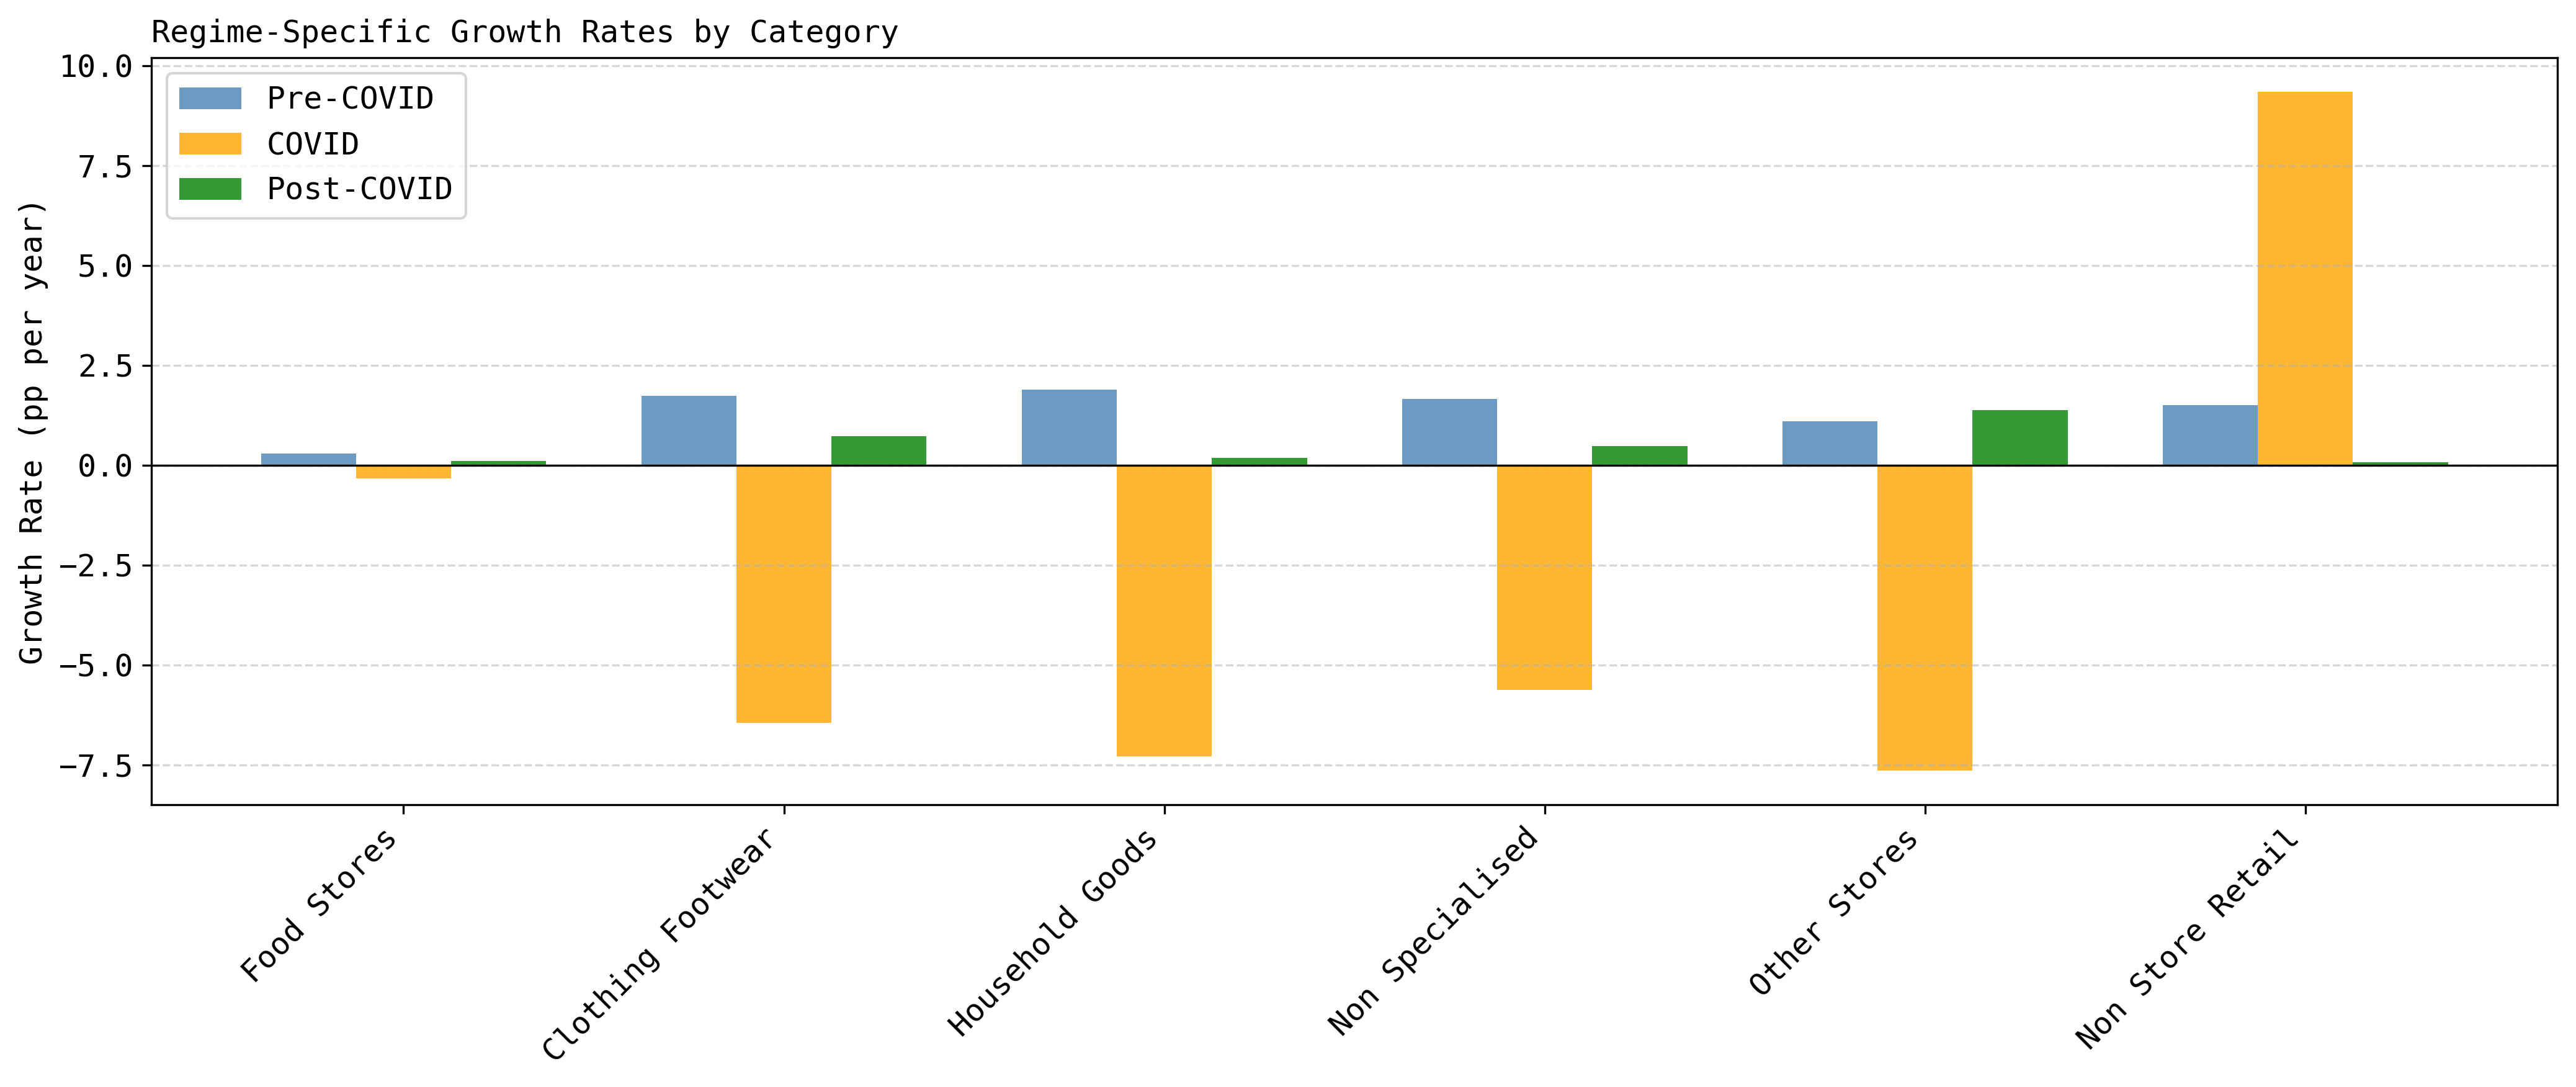

In [17]:
# Bar chart: Growth rates by regime and category
fig, ax = plt.subplots(figsize=(14, 6), dpi=300)

categories_plot = [cat for cat in categories if cat != 'all_retail_ex_fuel']
x = np.arange(len(categories_plot))
width = 0.25

pre_growth = [regime_profiles[cat]['pre']['growth'] for cat in categories_plot]
covid_growth = [regime_profiles[cat]['covid']['growth'] for cat in categories_plot]
post_growth = [regime_profiles[cat]['post']['growth'] for cat in categories_plot]

ax.bar(x - width, pre_growth, width, label='Pre-COVID', color='steelblue', alpha=0.8)
ax.bar(x, covid_growth, width, label='COVID', color='orange', alpha=0.8)
ax.bar(x + width, post_growth, width, label='Post-COVID', color='green', alpha=0.8)

ax.axhline(y=0, color='black', linewidth=0.8, linestyle='-')
ax.set_ylabel('Growth Rate (pp per year)')
ax.set_title('Regime-Specific Growth Rates by Category', loc='left', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels([cat.replace('_', ' ').title() for cat in categories_plot], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig(output_figures_dir / 'category_regime_growth_rates.png', bbox_inches='tight', dpi=300)
plt.show()

/tmp/ipykernel_9461/1901689224.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([cat.replace('_', ' ').title() for cat in categories_plot], rotation=45, ha='right')


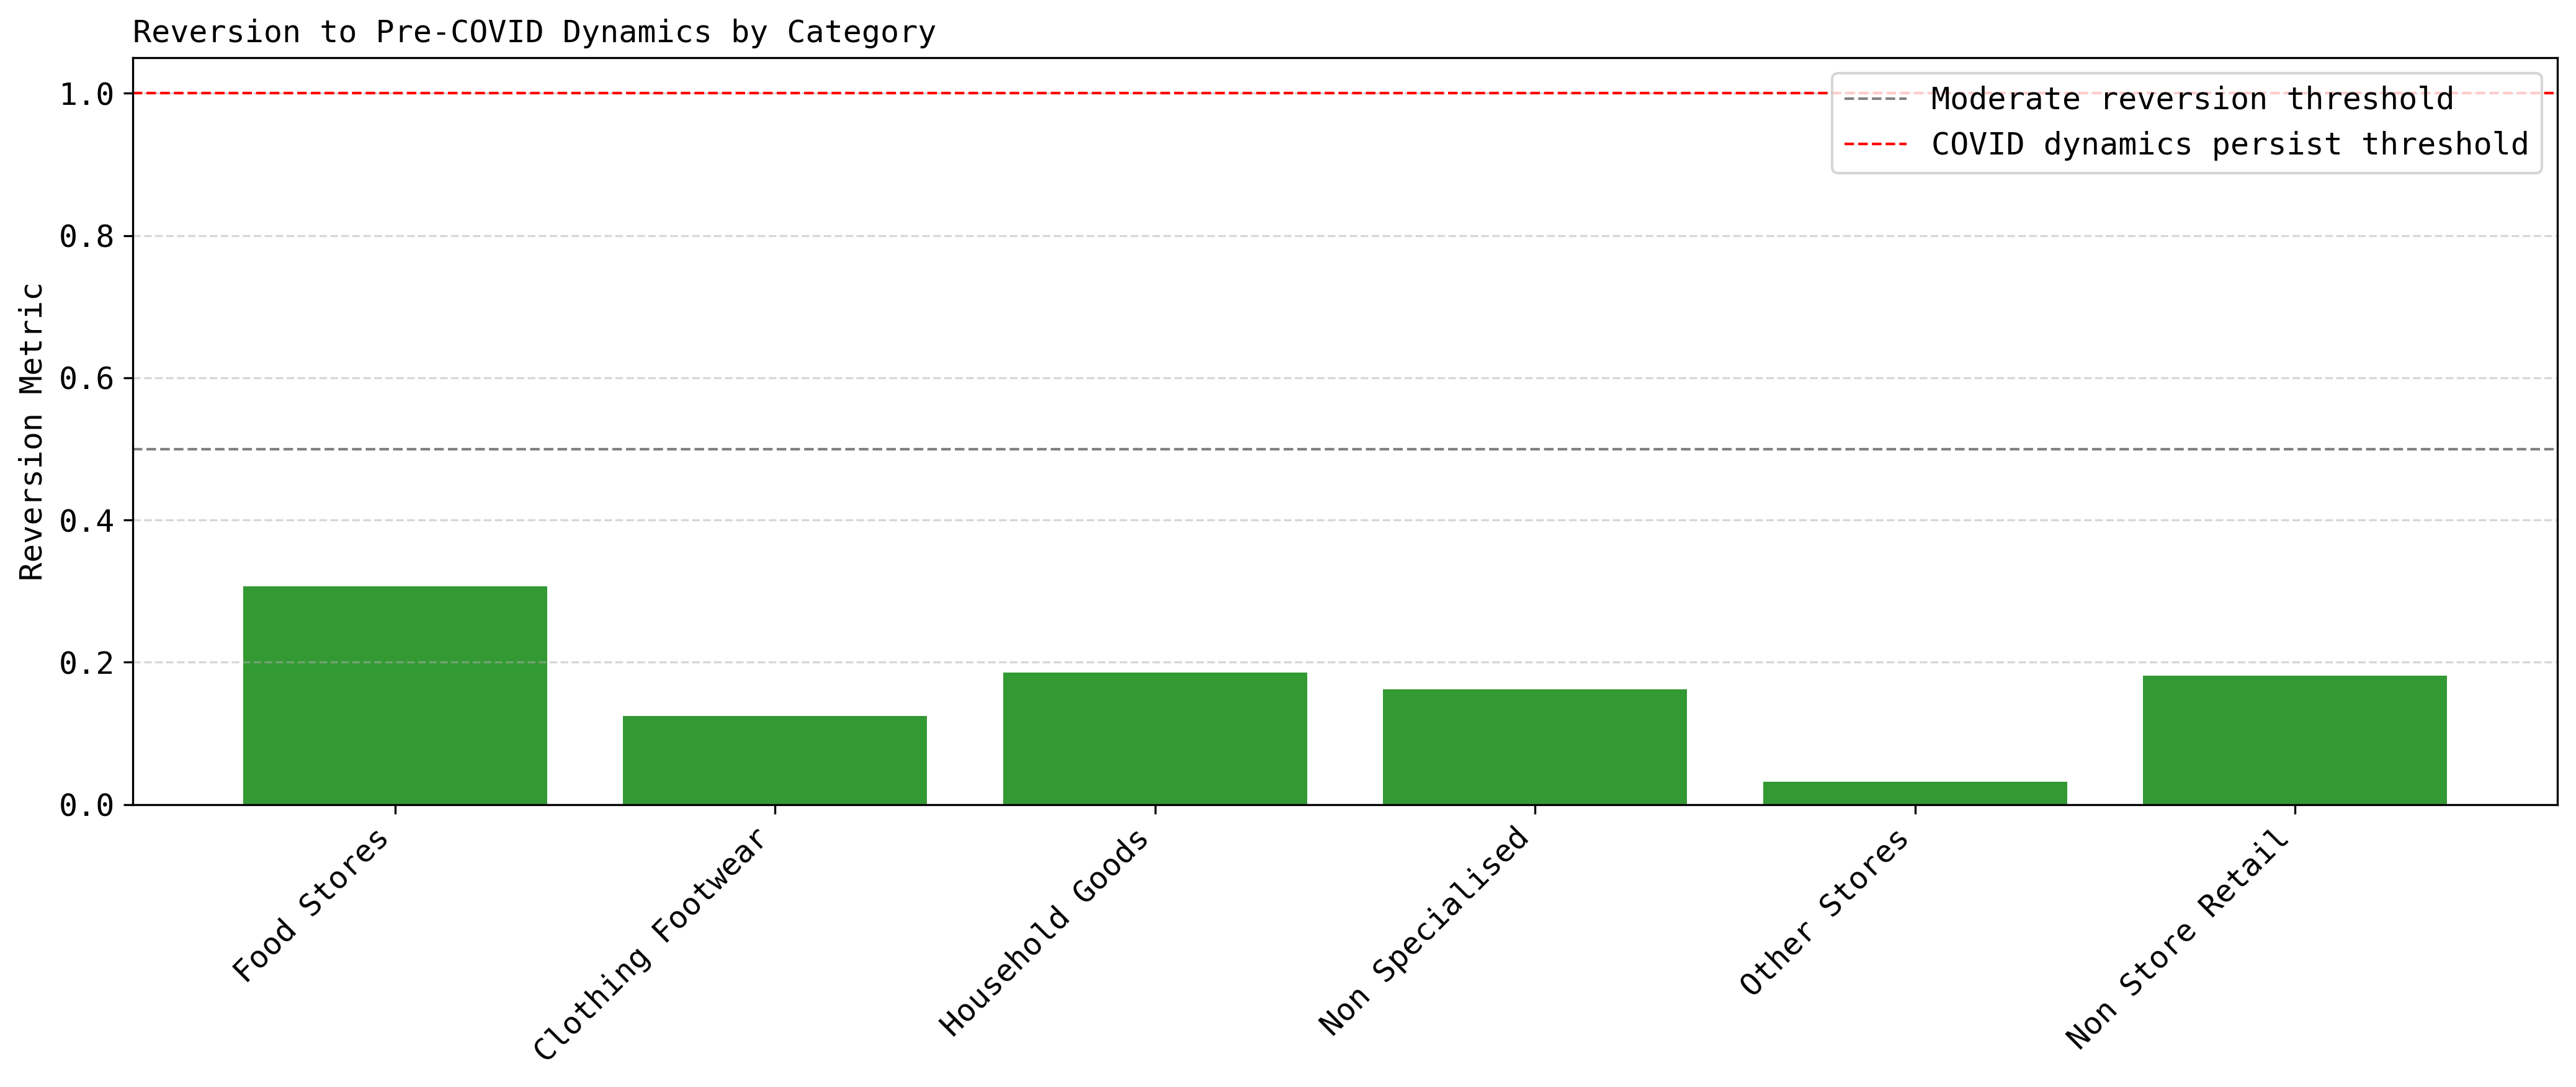

In [18]:
# Bar chart: Reversion metrics
fig, ax = plt.subplots(figsize=(14, 6), dpi=300)

categories_plot = [cat for cat in categories if cat != 'all_retail_ex_fuel']
reversion_values = [reversion_metrics[cat] for cat in categories_plot]

colors_reversion = ['green' if v < 0.5 else 'orange' if v < 1.0 else 'red' for v in reversion_values]

ax.bar(categories_plot, reversion_values, color=colors_reversion, alpha=0.8)
ax.axhline(y=0.5, color='gray', linewidth=1, linestyle='--', label='Moderate reversion threshold')
ax.axhline(y=1.0, color='red', linewidth=1, linestyle='--', label='COVID dynamics persist threshold')

ax.set_ylabel('Reversion Metric')
ax.set_title('Reversion to Pre-COVID Dynamics by Category', loc='left', fontsize=12)
ax.set_xticklabels([cat.replace('_', ' ').title() for cat in categories_plot], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig(output_figures_dir / 'category_reversion_metrics.png', bbox_inches='tight', dpi=300)
plt.show()

## 9. Save Results

In [19]:
# Save regime profiles and reversion metrics
regime_analysis_results = {
    'changepoints': {
        'indices': changepoints_validated,
        'dates': [df_categories.index[i] for i in changepoints_validated]
    },
    'regime_periods': {
        'pre_covid': {'start': df_categories.index[0], 'end': df_categories.index[break1_idx - 1], 'n_months': regime_pre.sum()},
        'covid': {'start': break1_date, 'end': df_categories.index[break2_idx - 1], 'n_months': regime_covid.sum()},
        'post_covid': {'start': break2_date, 'end': df_categories.index[-1], 'n_months': regime_post.sum()}
    },
    'regime_profiles': regime_profiles,
    'reversion_metrics': reversion_metrics
}

output_path = processed_data_dir / 'category_regime_analysis.pkl'
with open(output_path, 'wb') as f:
    pickle.dump(regime_analysis_results, f)

print(f'✅ Regime analysis results saved to {output_path}')

✅ Regime analysis results saved to /home/mikhailarutyunov/projects/time-series-methods/time-series-methods/data/processed/category_regime_analysis.pkl


In [20]:
# Save updated category data with regime dummies
output_path_data = processed_data_dir / 'category_data_with_regimes.pkl'
df_categories.to_pickle(output_path_data)
print(f'✅ Category data with regime dummies saved to {output_path_data}')

✅ Category data with regime dummies saved to /home/mikhailarutyunov/projects/time-series-methods/time-series-methods/data/processed/category_data_with_regimes.pkl


In [21]:
# Print completion message
print('\n' + '=' * 100)
print('📋 NOTEBOOK 05 COMPLETE')
print('=' * 100)
print(f'\nKey findings:')
print(f'  - Identified {len(changepoints_validated)} validated changepoints')
print(f'  - Defined 3 regimes: Pre-COVID ({regime_pre.sum()}m), COVID ({regime_covid.sum()}m), Post-COVID ({regime_post.sum()}m)')
print(f'  - Calculated regime-specific growth rates and reversion metrics for {len(categories)} categories')
print(f'\n✅ Ready for TabPFN forecasting in notebook 06')


📋 NOTEBOOK 05 COMPLETE

Key findings:
  - Identified 2 validated changepoints
  - Defined 3 regimes: Pre-COVID (63m), COVID (22m), Post-COVID (42m)
  - Calculated regime-specific growth rates and reversion metrics for 7 categories

✅ Ready for TabPFN forecasting in notebook 06
